<a href="https://colab.research.google.com/github/kanbanyte/sepb/blob/collab/src/notebooks/object_detection_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup dataset and working directory

In [ ]:
# Check for NVIDIA GPU
!nvidia-smi


In [ ]:
# Set up workspace directory

import os
ROOT_DIR = os.getcwd()
print("Root directory is: " + ROOT_DIR)

# Fix Google Collab occasional encoding error when using shell commands
# This function should be called at the start of every cell
def ensure_correct_locale():
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"


In [ ]:
# Install Roboflow and Dataset (with private API key)
ensure_correct_locale()
print("Installing Roboflow package")
%pip install roboflow --quiet

from roboflow import Roboflow
import getpass

api_key = getpass.getpass("Enter your Roboflow project API key: ")
rf = Roboflow(api_key=api_key)
print("Roboflow authenticated.")


In [ ]:
# Ensure that the following matches the intended dataset source:
# - Workspace name
# - Project name
# - Dataset version
# - Format
ensure_correct_locale()
print(f"Downloading dataset from Roboflow")
dataset_workspace = "sepb"
dataset_project = input("Enter dataset project: ")
dataset_version = int(input("Enter dataset version: "))

project = rf.workspace(dataset_workspace).project(dataset_project)
dataset = project.version(dataset_version).download("yolov5")

print("Fixing incorrect paths in 'data.yaml'")
import yaml
dataset_yaml_path = os.path.join(dataset.location, "data.yaml")
with open(dataset_yaml_path) as data_yaml:
    doc = yaml.safe_load(data_yaml)
doc['train'] = "../train/images"
doc['val'] = "../valid/images"
with open(dataset_yaml_path, 'w') as data_yaml:
    yaml.dump(doc, data_yaml)

print("Finished fixing incorrect paths in 'data.yaml'")


# Download YOLO model and start training.


In [ ]:
# Install dependencies from Ultralytics in quiet mode
ensure_correct_locale()
print("Installing Ultralytics dependencies")
from IPython import display
%pip install ultralytics==8.0.159 --quiet
import ultralytics
ultralytics.checks()

# Install YOLO model
from ultralytics import YOLO

print("Cloning YOLOv5 from GitHub")
!git clone https://github.com/ultralytics/yolov5 --quiet
%pip install -r {ROOT_DIR}/yolov5/requirements.txt --quiet


In [ ]:
# Configure the model training parameters

ensure_correct_locale()
frozen_layer_count = 0

def calculate_next_multiple(factor, number):
    # Calculates the multiple of `factor` and is cloest to `number` in the positive direction.
    # YOLO models requires the image length to be a multiple of `factor` so it
    # automatically converts the image size to that value and produce a warning message.

    remainder = number % factor
    if remainder > 0:
        current_factor = number // factor
        return factor * (current_factor + 1)

    return number

# According to the architecture of the model (.yaml file in yolov5/models), the backbone contains 10 layers
def freeze_backbone(trainer):
    model = trainer.model
    global frozen_layer_count

    print(f"Freezing {frozen_layer_count} backbone layers")
    freeze = [f'model.{x}.' for x in range(frozen_layer_count)]  # layers to freeze
    for k, v in model.named_parameters():
        v.requires_grad = True  # train all layers
        if any(x in k for x in freeze):
            print(f'Freezing {k}')
            v.requires_grad = False
    print(f"{frozen_layer_count} layers are freezed.")

def get_image_size(default=640):
    print(
'''
Enter image size. For rectangular images, enter the longer dimension.
\tNote:
\t1. Larger image size consumes more memory to train
\t2. Image size used for training and inference should be similar
\t3. YOLO will resize the longer dimension and apply grey-padding to maintain the aspect ratio.
''')
    image_size_input = input(f"Enter the image size (default: {default}): ")

    if not image_size_input:
        return default

    original_size = int(image_size_input)
    corrected_size = calculate_next_multiple(32, original_size)
    if corrected_size != original_size:
        print(f"Increasing resolution to {corrected_size} because dimensions must be a multiple of 32")
    return corrected_size

def get_epochs(default=60):
    epochs_input = input(f"Enter the number of epochs (default: {default}): ")
    return int(epochs_input) if epochs_input else default

def get_force_rect_training(default='y'):
    # According to this GitHub comment https://github.com/ultralytics/yolov5/issues/2009#issuecomment-766147324,
    # we should force rectangular training when using non-square images.
    # Note that rectangular inference is the default inference behavior, according to https://github.com/ultralytics/yolov5/issues/2009#issuecomment-765557040
    use_rectangular_training_input = input(f"Use rectangular training (y=yes/any key=no) (default: {default}): ")
    return use_rectangular_training_input == default or not use_rectangular_training_input

def get_model():
    model_choice = input("Enter the model choice (0 for small, 1 for medium, 2 for large, 3 for extra large): ")
    # Model with the `u` suffix are supposedly improved versions made by ultralytics
    if model_choice == "0":
        return "yolov5su.pt"
    elif model_choice == "1":
        return "yolov5mu.pt"
    elif model_choice == "2":
        return "yolov5l.pt"
    elif model_choice == "3":
        return "yolov5x.pt"
    else:
        print("Invalid model choice. Please choose 0-3.")
        exit(-1)

def get_frozen_layer_count(default=0):
    frozen_layer_count_input = input(f"Enter the number of layers to freeze (default: {default}): ")
    frozen_layer_count = int(frozen_layer_count_input) if frozen_layer_count_input else default
    if frozen_layer_count < 0 or frozen_layer_count > 10:
        print("Error: layer count must be between 0 and 10, inclusive")
        exit(-1)
    return frozen_layer_count

def get_batch_size(default=32):
    print("Enter the batch size. Batch size ranges from 16 with 512, with 32 being the rule of thumb.")
    batch_size_input = input(f"Enter the number of images in a batch (default: {default}): ")
    batch_size = int(batch_size_input) if batch_size_input else default
    return batch_size

%cd {ROOT_DIR}

epochs = get_epochs()
use_rectangular_training = get_force_rect_training()
image_size = get_image_size()
model_name = get_model()
frozen_layer_count = get_frozen_layer_count()
batch_size = get_batch_size()

# YOLO calculates the final learning rate as final_lr_factor * initial learning rate
final_lr_factor = 0.01
model = YOLO(model_name)

# The recommended way to freeze layers within the backbone is a callback https://github.com/ultralytics/ultralytics/issues/793#issuecomment-1510398080
model.add_callback("on_train_start", freeze_backbone)

print(f"Training model {model_name} with {epochs} epochs")
model.train(data=dataset_yaml_path, epochs=epochs, imgsz=image_size, cache=True, lrf=final_lr_factor, rect=use_rectangular_training, batch=batch_size)

# Setup result output paths for subsequent cells
train_folders = [folder for folder in os.listdir(f'{ROOT_DIR}/runs/detect') if folder.startswith("train") and not folder.endswith(".zip")]

# Extract the indices from folder names and find the highest index
# Retraining will output results in new folders with the name format: "train<index>"
indices = [int(folder[len("train"):] if folder[len("train"):] else 0) for folder in train_folders]
highest_index = "" if max(indices) == 0 else max(indices)
result_folder_path = f'{ROOT_DIR}/runs/detect/train{highest_index}'

# Records the training configuration to a yaml file
# The image size used for training and inference should be the same

ensure_correct_locale()
import yaml
import os
train_config = {
        "imageSize": image_size,
        "epochs": epochs,
        "model": model_name,
        "frozen_backbone_layers": frozen_layer_count,
        "rectangular_training": use_rectangular_training,
        "batch_size": batch_size,
        "dataset": {
                "workspace": dataset_workspace,
                "project": dataset_project,
                "version": dataset_version,
            }
    }

train_config_file = os.path.join(result_folder_path, 'training_config.yaml')
with open(train_config_file, 'w') as file:
    yaml.dump(train_config, file)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


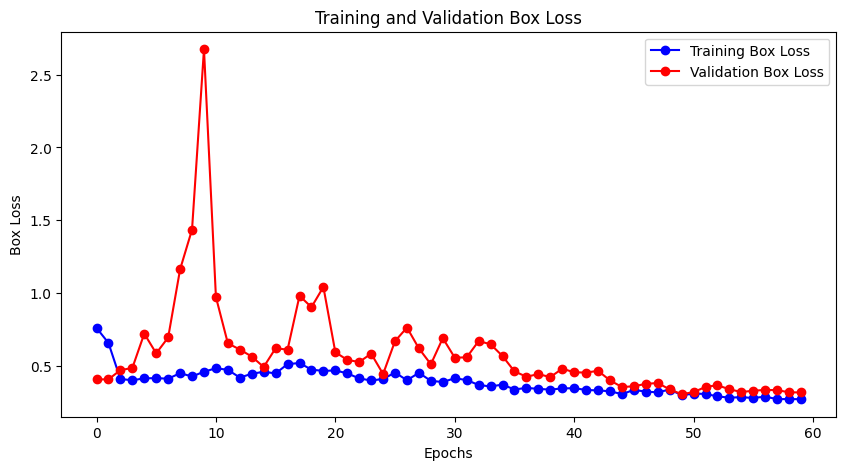

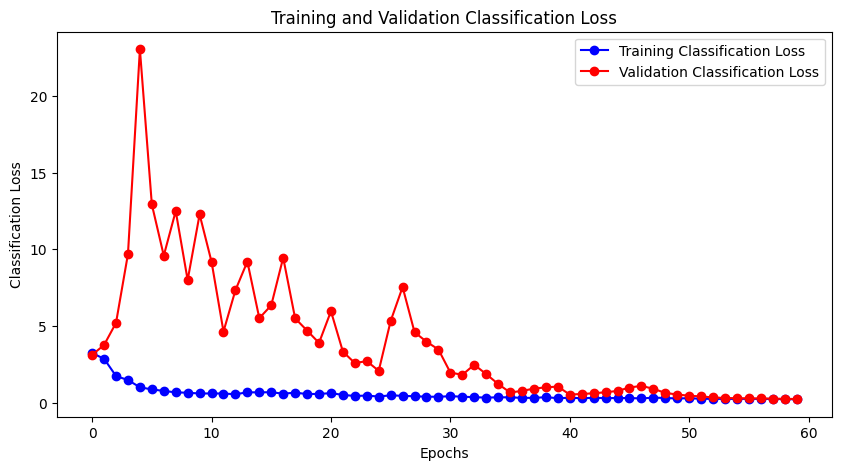

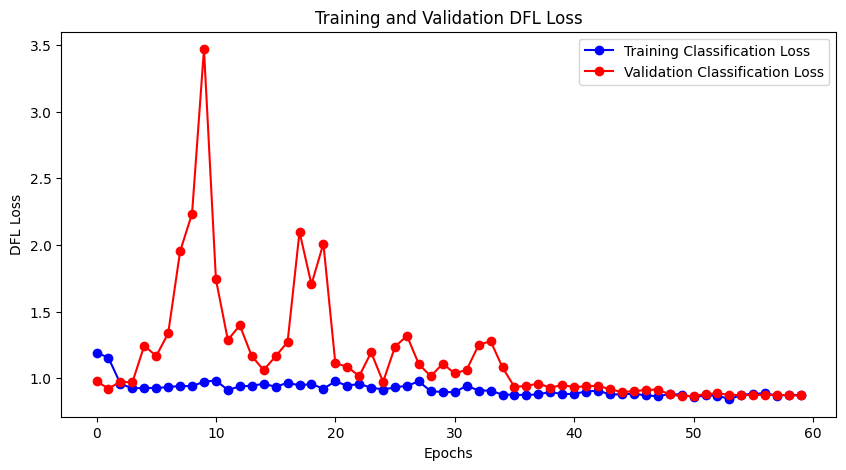

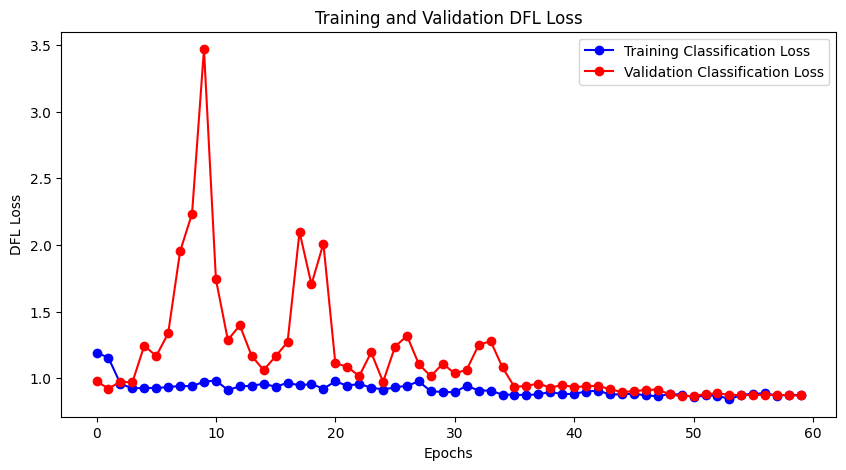

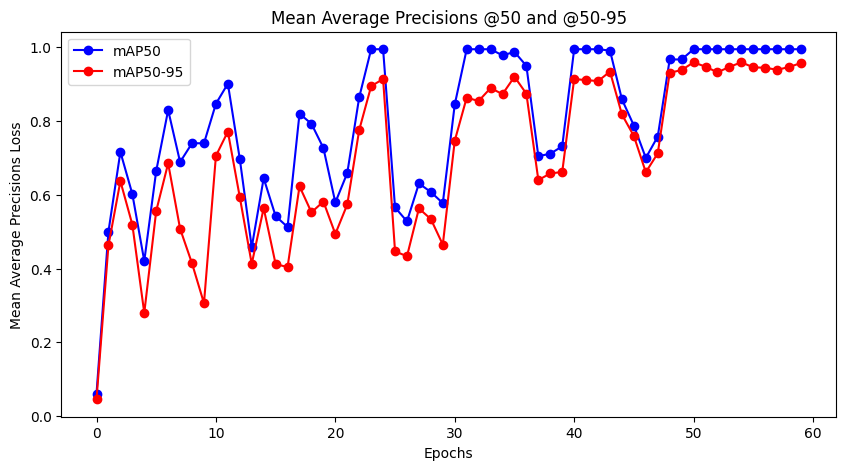

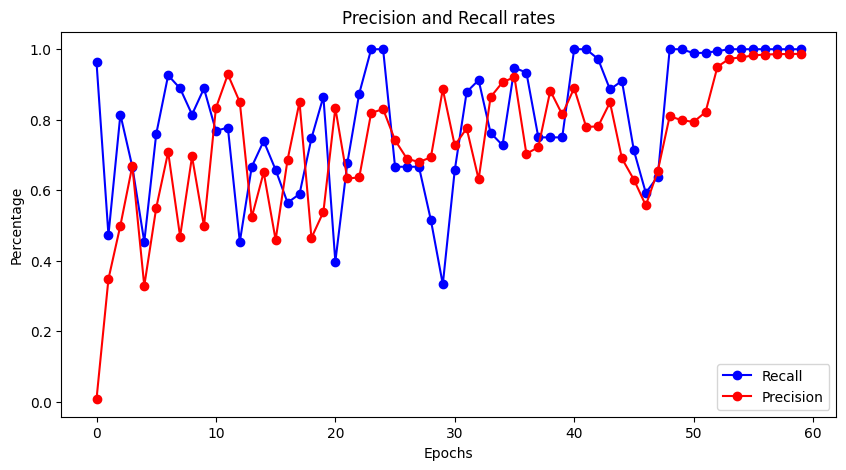

In [12]:
# Display the result summary
ensure_correct_locale()
import os
from IPython.display import Image, display

results_file_path = f'{result_folder_path}/results.png'
display(Image(filename=results_file_path, width=1200))

confusion_mat_file_path = f'{result_folder_path}/confusion_matrix.png'
display(Image(filename=confusion_mat_file_path, width=1200))

print(f"Displayed confusion matrix from {confusion_mat_file_path}")
print(f"Displayed result summary from {results_file_path}")

%pip install pandas --quiet
%pip install matplotlib --quiet
%pip install numpy --quiet

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results_csv =  os.path.join(result_folder_path, "results.csv")
df = pd.read_csv(results_csv)

# The csv file contains weird spaces before the text.
epochs = df['                  epoch']

# Display training and validation loss curves for box
training_box_loss = df['         train/box_loss']
validation_box_loss = df['           val/box_loss']
plt.figure(figsize=(10, 5))
plt.plot(epochs,  np.asarray(training_box_loss, float) , label='Training Box Loss', marker=',', color='blue')
plt.plot(epochs,  np.asarray(validation_box_loss, float) , label='Validation Box Loss', marker=',', color='red')
plt.xlabel('Epochs')
plt.ylabel('Box Loss')
plt.title('Training and Validation Box Loss')
plt.legend()
plt.show()

# Display training and validation loss curves for classification
training_cls_loss = df['         train/cls_loss']
validation_cls_loss = df['           val/cls_loss']
plt.figure(figsize=(10, 5))
plt.plot(epochs, np.asarray(training_cls_loss, float), label='Training Classification Loss', marker=',', color='blue')
plt.plot(epochs, np.asarray(validation_cls_loss, float), label='Validation Classification Loss', marker=',', color='red')
plt.xlabel('Epochs')
plt.ylabel('Classification Loss')
plt.title('Training and Validation Classification Loss')
plt.legend()
plt.show()

# Display training and validation loss curves for DFL
training_dfl_loss = df['         train/dfl_loss']
validation_dfl_loss = df['           val/dfl_loss']
plt.figure(figsize=(10, 5))
plt.plot(epochs, np.asarray(training_dfl_loss, float), label='Training DFL Loss', marker=',', color='blue')
plt.plot(epochs, np.asarray(validation_dfl_loss, float), label='Validation DFL Loss', marker=',', color='red')
plt.xlabel('Epochs')
plt.ylabel('DFL Loss')
plt.title('Training and Validation DFL Loss')
plt.legend()
plt.show()

# Display training and validation loss curves for mean average precision
maAP50 = df['       metrics/mAP50(B)']
mAP50_95 = df['    metrics/mAP50-95(B)']
plt.figure(figsize=(10, 5))
plt.plot(epochs, maAP50, label='mAP50', marker=',', color='blue')
plt.plot(epochs, mAP50_95, label='mAP50-95', marker=',', color='red')
plt.xlabel('Epochs')
plt.ylabel('Mean Average Precisions Loss')
plt.title('Mean Average Precisions @50 and @50-95')
plt.legend()
plt.show()

# Display training and validation loss curves for precision and recall rates
recall = df['      metrics/recall(B)']
precision = df['   metrics/precision(B)']
plt.figure(figsize=(10, 5))
plt.plot(epochs, recall, label='Recall', marker=',', color='blue')
plt.plot(epochs, precision, label='Precision', marker=',', color='red')
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.title('Precision and Recall rates')
plt.legend()
plt.show()


In [ ]:
# This cell is only applicable when the notebook is run in Google Collab
# Downloading models files and results in a ZIP folder
from datetime import datetime, timedelta

ensure_correct_locale()

# Format the zip file name with local Australian time
current_utc_time = datetime.utcnow()
dst_change = datetime(2023, 10, 1, 2, 0, 0)
time_difference = timedelta(hours=10) if current_utc_time < dst_change else timedelta(hours=11)
current_datetime = (current_utc_time + time_difference).strftime("%Y-%m-%dT%H-%M-%S")
zip_folder_path = f'{ROOT_DIR}/runs/detect/train-{current_datetime}'

# Avoid empty parent folders in zip file by cd-ing to the folder before zipping it
%cd {result_folder_path}
!zip -r {zip_folder_path} *

from google.colab import files

zip_file = f'{zip_folder_path}.zip'
zip_file_size_mb = os.path.getsize(zip_file) / (1024 * 1024)
download = input(f"Press 'y' to download result zip file ({zip_file_size_mb:.2f} MB) '{zip_file}': ")
if download == 'y':
    print(f"Downloading zip file {zip_file}")
    files.download(zip_file)
